# 13.2b: Outlier Detection in Dead Token Cluster (bfloat16)

**Goal:** Identify potential contamination - tokens that moved slightly during training vs truly frozen dead tokens.

## Hypothesis

Dead tokens are **frozen at initialization** - they received zero gradient updates during training.

Our 134 unique vectors might include:
- **True dead tokens:** Never moved, tightly clustered at initialization point
- **Contamination:** Tokens that moved slightly during training but stayed close

## Method

1. Load the 134 unique dead token vectors **in bfloat16**
2. Compute pairwise L∞ (Chebyshev) distances **in bfloat16**
3. Identify outliers: vectors far from the dense core
4. Visualize distance distribution to find separation threshold
5. Report which tokens are likely contamination

**Note:** Working in bfloat16 directly, no epsilon scaling - we want exact bfloat16 values.

## Parameters

In [13]:
# Input
DEAD_TOKENS_PATH = "../data/tensors/13.1a_dead_tokens.safetensors"

# Figure settings
DPI = 150

RANDOM_SEED = 42

## Imports

In [14]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from safetensors.torch import load_file

torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print("✓ Imports complete")

✓ Imports complete


## Load Dead Token Embeddings

In [15]:
print("Loading dead token embeddings...\n")

data = load_file(DEAD_TOKENS_PATH)

# Load bfloat16 embeddings
dead_embeddings_bf16 = data['dead_embeddings_bfloat16']
dead_embeddings_f32 = data['dead_embeddings_float32']
dead_token_ids = data['dead_token_ids']

print(f"✓ Loaded dead token embeddings")
print(f"  Shape: {dead_embeddings_bf16.shape}")
print(f"  bfloat16 dtype: {dead_embeddings_bf16.dtype}")

n_dead = len(dead_embeddings_bf16)

Loading dead token embeddings...

✓ Loaded dead token embeddings
  Shape: torch.Size([2221, 2560])
  bfloat16 dtype: torch.bfloat16


## Extract Unique Vectors (bfloat16)

In [16]:
print("\nExtracting unique vectors in bfloat16...\n")

# Use float32 to find unique indices (since torch.unique works better with f32)
# but extract bfloat16 versions
unique_vectors_f32, inverse, counts = torch.unique(
    dead_embeddings_f32, dim=0, return_inverse=True, return_counts=True
)

n_unique = len(unique_vectors_f32)
n_singletons = (counts == 1).sum().item()
n_black_holes = (counts >= 2).sum().item()

# Extract bfloat16 versions using inverse indices
unique_indices = []
for i in range(n_unique):
    first_idx = (inverse == i).nonzero()[0].item()
    unique_indices.append(first_idx)

unique_vectors_bf16 = dead_embeddings_bf16[unique_indices]
unique_token_ids = dead_token_ids[unique_indices]

print(f"✓ Found {n_unique} unique vectors")
print(f"  Singletons (count=1): {n_singletons}")
print(f"  Black holes (count≥2): {n_black_holes}")
print(f"\nWorking with bfloat16 data: {unique_vectors_bf16.shape}")


Extracting unique vectors in bfloat16...

✓ Found 134 unique vectors
  Singletons (count=1): 121
  Black holes (count≥2): 13

Working with bfloat16 data: torch.Size([134, 2560])


## Compute Pairwise L∞ Distances (bfloat16)

In [17]:
print("\nComputing pairwise L∞ distances in bfloat16...\n")

# Use torch.cdist with bfloat16 vectors
# Convert to float32 temporarily for cdist (it doesn't support bfloat16)
# but the values will be exact bfloat16 values
l_inf_matrix = torch.cdist(
    unique_vectors_bf16.to(torch.float32), 
    unique_vectors_bf16.to(torch.float32), 
    p=float('inf')
)

print(f"✓ Computed {n_unique}×{n_unique} pairwise distances")
print(f"\nL∞ distance statistics (raw bfloat16 values):")
print(f"  Min (excluding diagonal): {l_inf_matrix[l_inf_matrix > 0].min().item():.6e}")
print(f"  Max: {l_inf_matrix.max().item():.6e}")
print(f"  Mean: {l_inf_matrix.mean().item():.6e}")
print(f"  Median: {l_inf_matrix.median().item():.6e}")


Computing pairwise L∞ distances in bfloat16...

✓ Computed 134×134 pairwise distances

L∞ distance statistics (raw bfloat16 values):
  Min (excluding diagonal): 7.450581e-09
  Max: 9.765625e-04
  Mean: 9.489565e-05
  Median: 3.051758e-05


## Analyze Distance Distribution

In [18]:
# Get upper triangle (exclude diagonal and duplicates)
triu_indices = torch.triu_indices(n_unique, n_unique, offset=1)
pairwise_distances = l_inf_matrix[triu_indices[0], triu_indices[1]]

print(f"\nPairwise distance distribution ({len(pairwise_distances)} unique pairs):")
print(f"  Min: {pairwise_distances.min().item():.6e}")
print(f"  Max: {pairwise_distances.max().item():.6e}")
print(f"  Mean: {pairwise_distances.mean().item():.6e}")
print(f"  Median: {pairwise_distances.median().item():.6e}")

# Look at percentiles
percentiles = [50, 75, 90, 95, 99, 99.9, 100]
print(f"\nPercentiles:")
for p in percentiles:
    val = torch.quantile(pairwise_distances, p/100).item()
    print(f"  {p:5.1f}%: {val:12.6e}")


Pairwise distance distribution (8911 unique pairs):
  Min: 7.450581e-09
  Max: 9.765625e-04
  Mean: 9.560915e-05
  Median: 3.051758e-05

Percentiles:
   50.0%: 3.051758e-05
   75.0%: 3.051758e-05
   90.0%: 4.882812e-04
   95.0%: 4.882812e-04
   99.0%: 6.103516e-04
   99.9%: 9.765625e-04
  100.0%: 9.765625e-04


## Figure 1: Distance Distribution

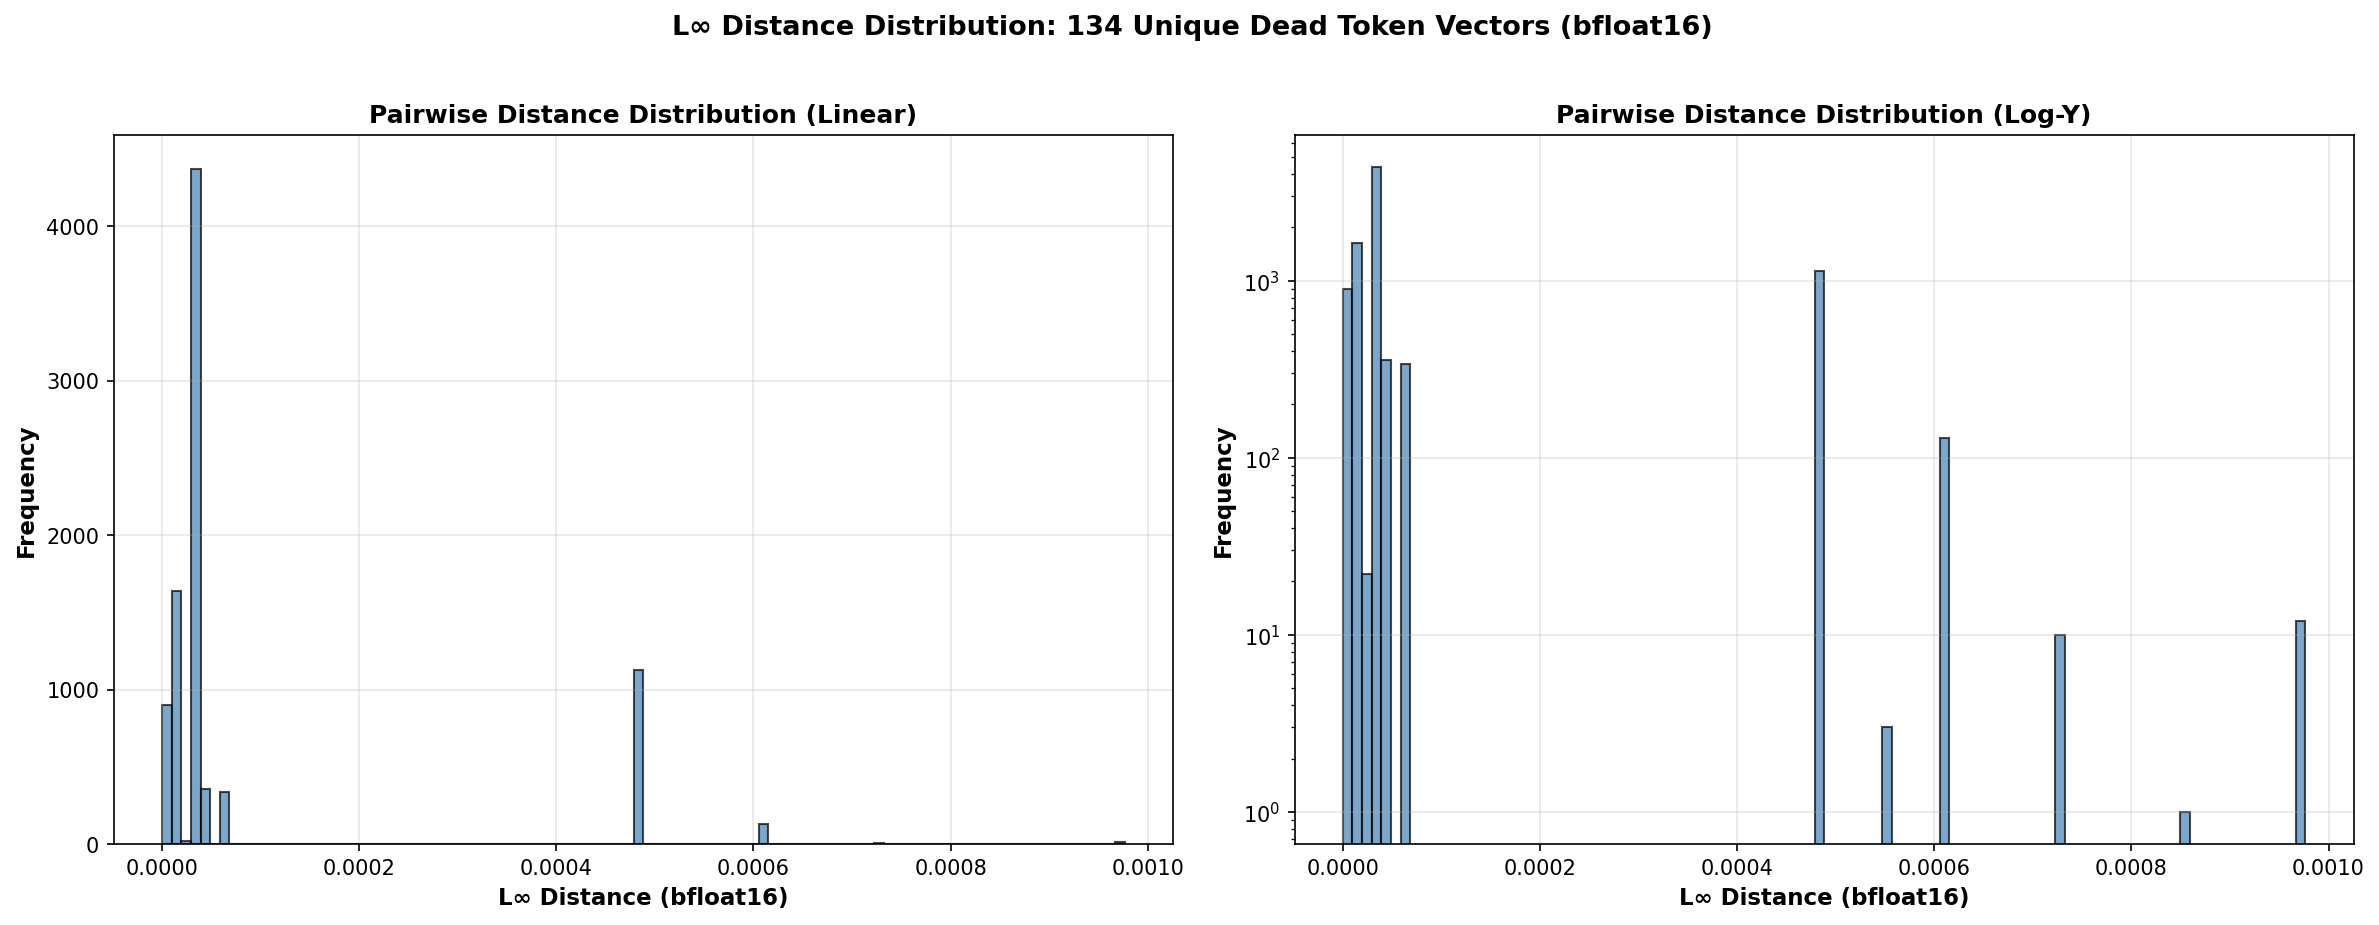

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), dpi=DPI)

distances_np = pairwise_distances.cpu().numpy()

# Left: Linear scale
ax = axes[0]
ax.hist(distances_np, bins=100, color='steelblue', alpha=0.7, edgecolor='black')
ax.set_xlabel('L∞ Distance (bfloat16)', fontsize=11, fontweight='bold')
ax.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax.set_title('Pairwise Distance Distribution (Linear)', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)

# Right: Log-y scale to see tail
ax = axes[1]
ax.hist(distances_np, bins=100, color='steelblue', alpha=0.7, edgecolor='black')
ax.set_xlabel('L∞ Distance (bfloat16)', fontsize=11, fontweight='bold')
ax.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax.set_title('Pairwise Distance Distribution (Log-Y)', fontsize=12, fontweight='bold')
ax.set_yscale('log')
ax.grid(True, alpha=0.3)

plt.suptitle(f'L∞ Distance Distribution: {n_unique} Unique Dead Token Vectors (bfloat16)',
             fontsize=13, fontweight='bold', y=1.02)

plt.tight_layout()
plt.show()

## Identify Max Distance per Vector

In [20]:
print("\nAnalyzing per-vector maximum distances...\n")

# For each vector, find its maximum distance to any other vector
max_distances = torch.zeros(n_unique)
for i in range(n_unique):
    # Get all distances from vector i (excluding self)
    distances_from_i = l_inf_matrix[i, :]
    distances_from_i = distances_from_i[distances_from_i > 0]  # Exclude self
    max_distances[i] = distances_from_i.max()

# Sort by max distance
sorted_max_dist, sorted_indices = torch.sort(max_distances, descending=True)

print(f"Top 20 vectors by maximum distance to any other vector:")
print(f"{'Rank':>6} {'Token ID':>10} {'Max L∞':>15} {'Population':>12}")
print("-" * 50)

for i in range(min(20, n_unique)):
    idx = sorted_indices[i].item()
    token_id = unique_token_ids[idx].item()
    max_dist = sorted_max_dist[i].item()
    pop = counts[idx].item()
    
    print(f"{i+1:>6} {token_id:>10} {max_dist:>15.6e} {pop:>12}")


Analyzing per-vector maximum distances...

Top 20 vectors by maximum distance to any other vector:
  Rank   Token ID          Max L∞   Population
--------------------------------------------------
     1     127734    9.765625e-04            1
     2      27487    9.765625e-04            1
     3      79270    9.765625e-04            1
     4      83969    9.765625e-04            1
     5     142386    9.765625e-04            1
     6     136954    9.765625e-04            1
     7      83971    9.765625e-04            1
     8      88372    9.765625e-04            1
     9     151652    7.324219e-04            1
    10     151653    7.324219e-04            1
    11     133377    6.103516e-04            1
    12     151840    6.103516e-04            1
    13     132191    6.103516e-04            1
    14     151646    6.103516e-04            1
    15     143480    6.103516e-04            1
    16     124860    6.103516e-04            1
    17     149121    6.103516e-04            1
   

## Compute Distance from Core

In [21]:
print("\nComputing distances from core centroid...\n")

# Core centroid (in float32 for computation, but values are bfloat16)
core_centroid = unique_vectors_bf16.to(torch.float32).mean(dim=0)

# L∞ distance from each vector to centroid
distances_from_core = torch.max(
    torch.abs(unique_vectors_bf16.to(torch.float32) - core_centroid), dim=1
)[0]

# Sort by distance from core
sorted_core_dist, sorted_core_indices = torch.sort(distances_from_core, descending=True)

print(f"Distance from core statistics:")
print(f"  Min: {distances_from_core.min().item():.6e}")
print(f"  Max: {distances_from_core.max().item():.6e}")
print(f"  Mean: {distances_from_core.mean().item():.6e}")
print(f"  Median: {distances_from_core.median().item():.6e}")

print(f"\nTop 20 vectors farthest from core:")
print(f"{'Rank':>6} {'Token ID':>10} {'Dist from core':>18} {'Population':>12}")
print("-" * 55)

for i in range(min(20, n_unique)):
    idx = sorted_core_indices[i].item()
    token_id = unique_token_ids[idx].item()
    dist = sorted_core_dist[i].item()
    pop = counts[idx].item()
    
    print(f"{i+1:>6} {token_id:>10} {dist:>18.6e} {pop:>12}")


Computing distances from core centroid...

Distance from core statistics:
  Min: 1.457520e-05
  Max: 5.957764e-04
  Mean: 5.727901e-05
  Median: 2.038293e-05

Top 20 vectors farthest from core:
  Rank   Token ID     Dist from core   Population
-------------------------------------------------------
     1     136954       5.957764e-04            1
     2     127734       5.028546e-04            1
     3      83971       5.028546e-04            1
     4     151653       4.864596e-04            1
     5     142386       4.846379e-04            1
     6      79270       4.828162e-04            1
     7     151652       4.828162e-04            1
     8      88372       4.791729e-04            1
     9      27487       4.737079e-04            1
    10      83969       4.737079e-04            1
    11     136831       5.648006e-05            4
    12     136755       5.511381e-05            1
    13     141553       4.144944e-05            1
    14     139765       4.122173e-05            1

## Figure 2: Distance from Core Distribution

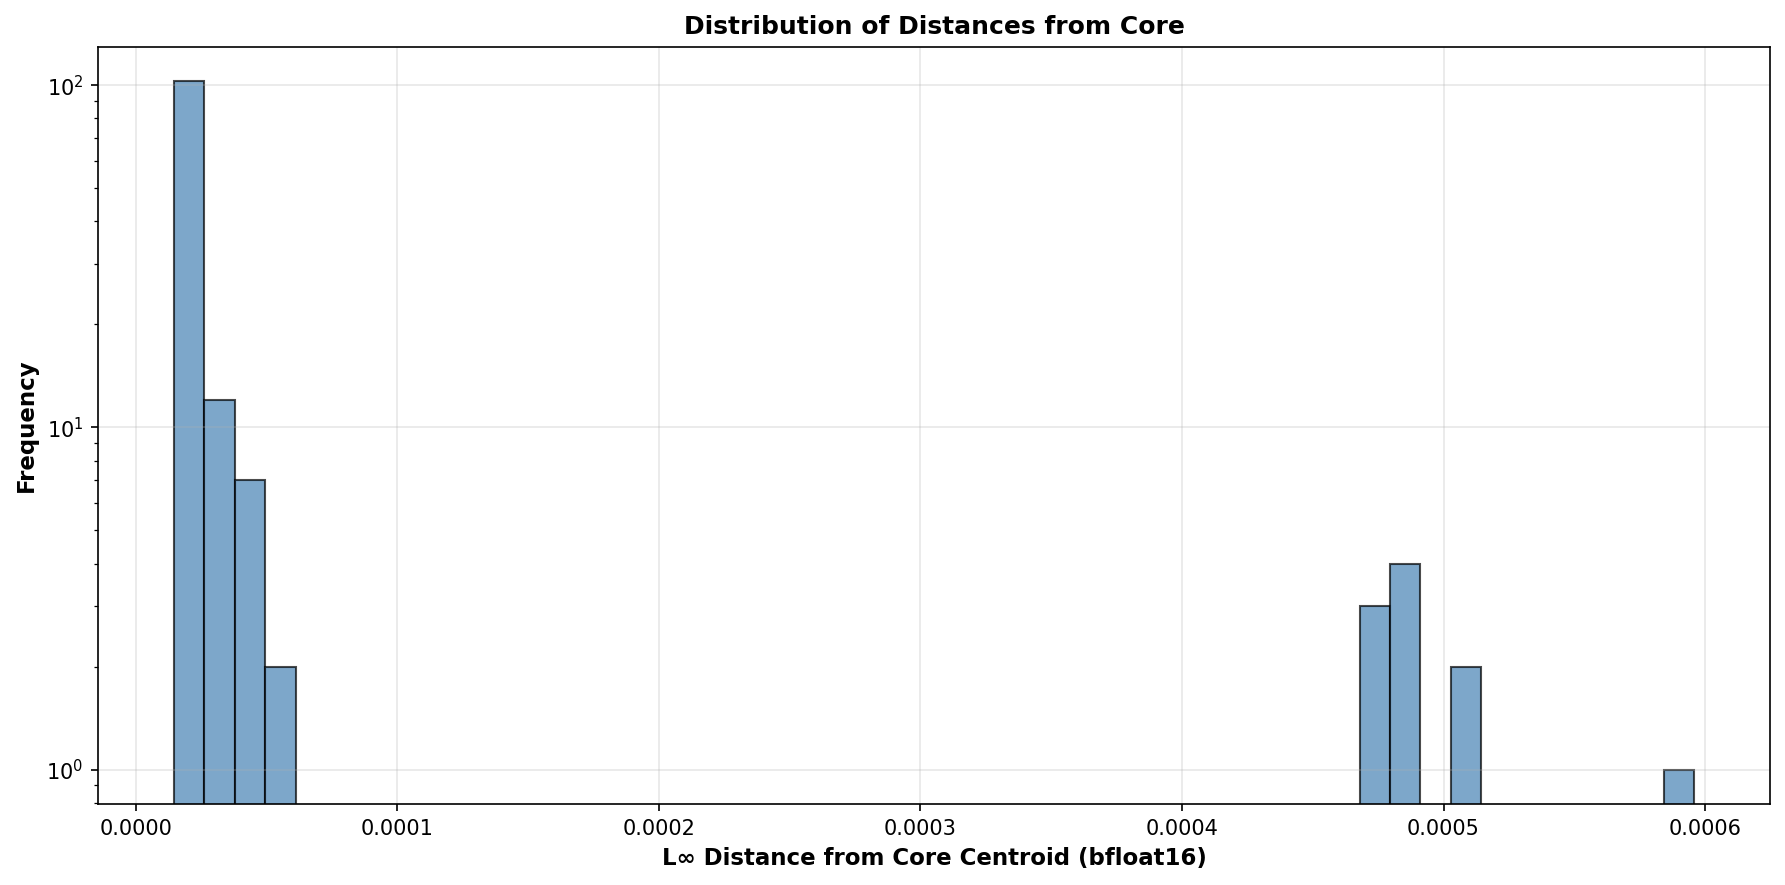

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6), dpi=DPI)

core_dist_np = distances_from_core.cpu().numpy()

ax.hist(core_dist_np, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
ax.set_xlabel('L∞ Distance from Core Centroid (bfloat16)', fontsize=11, fontweight='bold')
ax.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax.set_title('Distribution of Distances from Core', fontsize=12, fontweight='bold')
ax.set_yscale('log')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Look for Gaps in Sorted Distances

In [23]:
print("\nSearching for gaps in distance distribution...\n")

# Sort distances from core
sorted_distances = torch.sort(distances_from_core)[0]

# Compute gaps between consecutive distances
gaps = sorted_distances[1:] - sorted_distances[:-1]

# Find largest gaps
top_gaps_values, top_gaps_indices = torch.topk(gaps, k=min(10, len(gaps)))

print(f"Top 10 largest gaps:")
print(f"{'Rank':>6} {'After idx':>11} {'Gap size':>18} {'Threshold':>18}")
print("-" * 60)

for i in range(len(top_gaps_values)):
    idx = top_gaps_indices[i].item()
    gap = top_gaps_values[i].item()
    threshold = (sorted_distances[idx] + sorted_distances[idx + 1]).item() / 2
    
    print(f"{i+1:>6} {idx:>11} {gap:>18.6e} {threshold:>18.6e}")
    
# Show how many vectors would be flagged as outliers at largest gap
if len(top_gaps_values) > 0:
    largest_gap_idx = top_gaps_indices[0].item()
    threshold = (sorted_distances[largest_gap_idx] + sorted_distances[largest_gap_idx + 1]).item() / 2
    n_outliers = (distances_from_core > threshold).sum().item()
    n_core = n_unique - n_outliers
    
    print(f"\n→ Using threshold at largest gap ({threshold:.6e}):")
    print(f"   Core vectors: {n_core}")
    print(f"   Outliers: {n_outliers}")
    
    if n_outliers > 0:
        print(f"\nOutlier token IDs:")
        outlier_mask = distances_from_core > threshold
        outlier_indices = torch.where(outlier_mask)[0]
        for idx in outlier_indices:
            token_id = unique_token_ids[idx].item()
            dist = distances_from_core[idx].item()
            pop = counts[idx].item()
            print(f"  Token {token_id:6d}: dist={dist:.6e}, population={pop}")


Searching for gaps in distance distribution...

Top 10 largest gaps:
  Rank   After idx           Gap size          Threshold
------------------------------------------------------------
     1         123       4.172279e-04       2.650940e-04
     2         132       9.292178e-05       5.493155e-04
     3         130       1.639500e-05       4.946571e-04
     4         121       1.366436e-05       4.828162e-05
     5         106       5.465932e-06       3.051758e-05
     6         125       5.465001e-06       4.764404e-04
     7         126       3.643334e-06       4.809946e-04
     8          35       2.846820e-06       1.850410e-05
     9         113       1.935754e-06       3.660959e-05
    10          33       1.821900e-06       1.605588e-05

→ Using threshold at largest gap (2.650940e-04):
   Core vectors: 124
   Outliers: 10

Outlier token IDs:
  Token  88372: dist=4.791729e-04, population=1
  Token  27487: dist=4.737079e-04, population=1
  Token  79270: dist=4.828162e-04, popu

## Summary

In [24]:
print(f"\n{'='*80}")
print(f"OUTLIER DETECTION SUMMARY (bfloat16)")
print(f"{'='*80}")
print(f"\nAnalyzed {n_unique} unique dead token vectors ({n_singletons} singletons + {n_black_holes} black holes)")
print(f"\nPairwise L∞ distances:")
print(f"  Range: {pairwise_distances.min().item():.6e} - {pairwise_distances.max().item():.6e}")
print(f"  95th percentile: {torch.quantile(pairwise_distances, 0.95).item():.6e}")
print(f"\nDistance from core centroid:")
print(f"  Range: {distances_from_core.min().item():.6e} - {distances_from_core.max().item():.6e}")

if len(top_gaps_values) > 0 and n_outliers > 0:
    print(f"\nLargest gap separates {n_core} core vectors from {n_outliers} potential outliers")
    print(f"  Threshold: {threshold:.6e}")
    print(f"\n→ Recommend re-running 13.1a with tighter threshold to exclude {n_outliers} outliers")
elif len(top_gaps_values) > 0:
    print(f"\n→ No clear outliers detected - all vectors are tightly clustered")

print(f"\n{'='*80}")


OUTLIER DETECTION SUMMARY (bfloat16)

Analyzed 134 unique dead token vectors (121 singletons + 13 black holes)

Pairwise L∞ distances:
  Range: 7.450581e-09 - 9.765625e-04
  95th percentile: 4.882812e-04

Distance from core centroid:
  Range: 1.457520e-05 - 5.957764e-04

Largest gap separates 124 core vectors from 10 potential outliers
  Threshold: 2.650940e-04

→ Recommend re-running 13.1a with tighter threshold to exclude 10 outliers

